In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set()

In [4]:
df = yf.download('AAPL', start= '2021-01-01', end='2025-01-01', auto_adjust = True)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-01-04,126.405228,130.507705,123.816757,130.419798,143301900
2021-01-05,127.968063,128.681124,125.447967,125.897293,97664900
2021-01-06,123.660469,128.007149,123.445576,124.754466,155088000
2021-01-07,127.880203,128.573725,124.891255,125.379646,109578200
2021-01-08,128.983948,129.550483,127.206199,129.355114,105158200


In [6]:
number_simulations = 100
predict_days = 300

# 1) Extract closing prices as a Series
prices = df['Close']

# 2) Compute daily returns
returns = prices.pct_change().dropna()

# 3) Pull last observed price
last_price = prices.iloc[-1]

# 4) Compute statistics
avg_daily_ret = returns.mean()           # \bar r
daily_vol = returns.std()                # σ

# 5) Drift under geometric Brownian motion
#    μ_drift = \bar r - 0.5 * σ²
drift = avg_daily_ret - 0.5 * daily_vol**2

# 6) Prepare container for results
results = pd.DataFrame()

In [7]:

results = pd.DataFrame(index=range(predict_days + 1),
                       columns=range(number_simulations),
                       dtype=float)

last_price = df['Close'].iloc[-1]

for i in tqdm(range(number_simulations), desc="MC simulations"):
    # initialize path
    prices = [last_price]

    for _ in range(predict_days):
        # single-step shock, scalar
        shock = drift + daily_vol * np.random.normal()
        next_price = prices[-1] * np.exp(shock)
        prices.append(next_price)

    # assign the full path to column i
    results[i] = prices

MC simulations: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


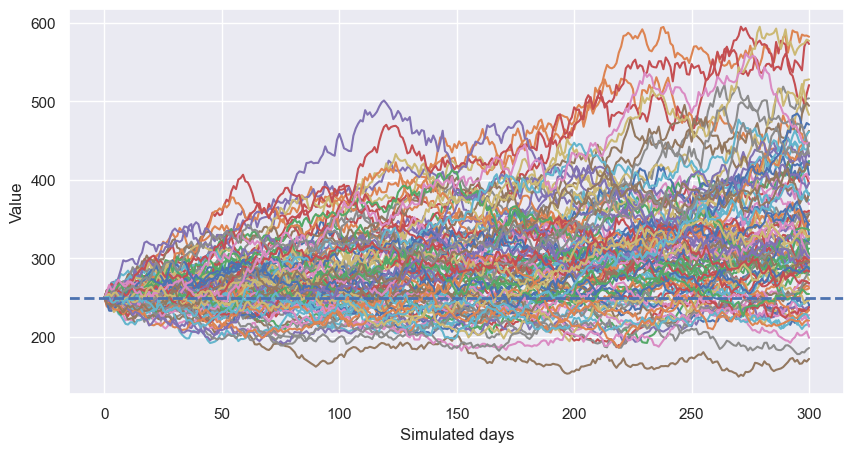

In [10]:
plt.figure(figsize=(10,5))
plt.plot(results)
plt.axhline(color = "b", linestyle = "dashed", y = last_price[0], linewidth = 2)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()


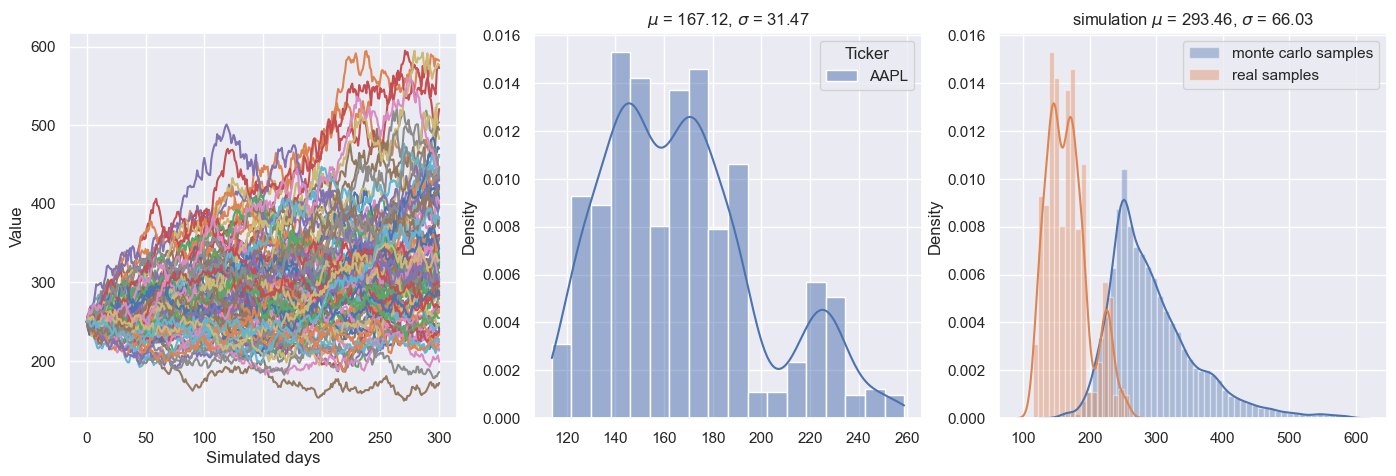

In [9]:
raveled = np.array(results.values.ravel(), dtype=float)

plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')

plt.subplot(1,3,2)
sns.histplot(df.Close, stat='density', kde=True)
plt.title('$\\mu$ = %.2f, $\\sigma$ = %.2f' % (df.Close.mean(), df.Close.std()))

float(df.Close.mean())
float(df.Close.std())

plt.subplot(1,3,3)
sns.distplot(raveled, norm_hist=True, label='monte carlo samples')
sns.distplot(df.Close, norm_hist=True, label='real samples')
plt.title('simulation $\\mu$ = %.2f, $\\sigma$ = %.2f' % (raveled.mean(), raveled.std()))
plt.legend()
plt.show()
